# Recon Data Sunshine (Time Series Forecasting)

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import missingno as msn
from tqdm.notebook import tqdm_notebook as tqdm
import scipy.stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression

## Data Extraction

In [2]:
recon_data=pd.read_excel('D:\Dataset\ReconData_Sunshine_till31Oct (002).xlsx')

## Exploratory Data Analysis

In [3]:
print("Number of samples in the dataset : ",recon_data.shape[0])
print("\nNumber of features in the dataset : ",recon_data.shape[1])
print("\nList of Columns from the dataset : ",list(recon_data.columns.values))

Number of samples in the dataset :  231224

Number of features in the dataset :  12

List of Columns from the dataset :  ['ID', 'JobID', 'JobType', 'Tech', 'CompletedDate', 'Qty', 'SOW', 'Total', 'LocationID', 'CreatedOn', 'LocationName', 'MSO']


In [4]:
print("print the top 5 records :")
recon_data.head()

print the top 5 records :


ID     JobID JobType     Tech CompletedDate  Qty              SOW   Total  \
0   1  86030630     NaN  29096.0    2018-09-04   14   CPP Commercial   73.50   
1   2  86050369     NaN  29096.0    2018-09-07   14   CPP Commercial   73.50   
2   3  86084293     NaN  60124.0    2018-09-07   33   CPP Commercial  173.25   
3   4  86146316     NaN  91166.0    2018-09-07  124   CPP Commercial  651.00   
4   5  86298711     NaN  96179.0    2018-09-06   15  CPP Residential   70.05   

   LocationID               CreatedOn     LocationName  MSO  
0          14 2018-09-24 14:19:24.047  South San Diego  COX  
1          14 2018-09-24 14:19:24.047  South San Diego  COX  
2          14 2018-09-24 14:19:24.047  South San Diego  COX  
3          14 2018-09-24 14:19:24.047  South San Diego  COX  
4          14 2018-09-24 14:19:24.047  South San Diego  COX

In [5]:
print("print the bottom 5 records :")
recon_data.tail()

print the bottom 5 records :


ID     JobID JobType     Tech CompletedDate  Qty              SOW  \
231219  403128  90797457      TC  90519.0    2019-11-10    8  CPP Residential   
231220  403129  90805364      SR   2129.0    2019-11-10    9  CPP Residential   
231221  403130  90799862      DW  38212.0    2019-11-10    9  CPP Residential   
231222  403131  90800446      DW  49381.0    2019-11-10    9  CPP Residential   
231223  403132  90805495      DW  57134.0    2019-11-10    9  CPP Residential   

        Total  LocationID               CreatedOn     LocationName  MSO  
231219  38.88          14 2019-11-12 05:23:39.137  South San Diego  COX  
231220  43.74          14 2019-11-12 05:23:39.137  South San Diego  COX  
231221  43.74          17 2019-11-12 05:23:39.137  North San Diego  COX  
231222  43.74          14 2019-11-12 05:23:39.137  South San Diego  COX  
231223  43.74          17 2019-11-12 05:23:39.137  North San Diego  COX

In [6]:
recon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231224 entries, 0 to 231223
Data columns (total 12 columns):
ID               231224 non-null int64
JobID            231224 non-null int64
JobType          156539 non-null object
Tech             228470 non-null float64
CompletedDate    231224 non-null datetime64[ns]
Qty              231224 non-null int64
SOW              231216 non-null object
Total            231223 non-null float64
LocationID       231224 non-null int64
CreatedOn        231224 non-null datetime64[ns]
LocationName     231224 non-null object
MSO              231224 non-null object
dtypes: datetime64[ns](2), float64(2), int64(4), object(4)
memory usage: 21.2+ MB


In [7]:
# Removed the features which does not provide the information to Model while predictoing the Total value.
# deletion was done with the  help of domain experts
recon_data.drop(['ID','JobID','Tech','CreatedOn','LocationID','MSO'],axis=1,inplace=True)

In [8]:
recon_data.describe().T

count       mean         std   min    25%    50%    75%      max
Qty    231224.0  16.008624   92.437472   1.0   8.00  13.00  18.00  43399.0
Total  231223.0  75.876004  103.766060 -35.7  38.88  63.96  88.73  21479.6

In [9]:
def detect_outlier(col):
    
    mean_total=np.mean(recon_data[col])
    std_total=np.std(recon_data[col])
    three_std_total= 3 * std_total

    print("Mean value of the {} feature : {} ".format(col,np.round(mean_total,3)))
    print("Standard deviation value of the {} feature : {} ".format(col,np.round(std_total,3)))
    
    outliers=[]
    index=0
    
    for each_val in tqdm(recon_data[col].values):
        if(np.abs(each_val-np.mean(recon_data[col])/np.std(recon_data[col])) > three_std_total):
            outliers.append(index)
        index=index+1
    
    return outliers

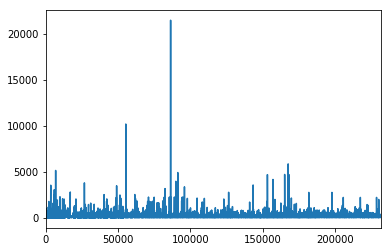

In [11]:
recon_data['Total'].plot()
plt.show()

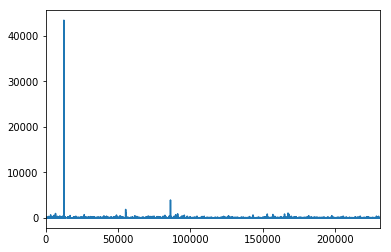

In [12]:
recon_data['Qty'].plot()
plt.show()

In [ ]:
total_outlier_index=detect_outlier('Total')
total_outlier_df=recon_data.loc[total_outlier_index]

In [ ]:
np.round(len(total_outlier_index)/recon_data.shape[0]*100,3)

In [ ]:
total_outlier_df.to_excel('total_outlier_df.xlsx',index=False)

In [ ]:
qty_outlier_index=detect_outlier('Qty')
qty_outlier_df=recon_data.loc[qty_outlier_index]

In [ ]:
qty_outlier_df.shape[0]/recon_data.shape[0]*100

In [ ]:
qty_outlier_df.to_excel('qty_outlier_df.xlsx',index=False)

In [ ]:
np.round(len(qty_outlier_index)/recon_data.shape[0]*100,3)

In [ ]:
def plot_outliers(data,col,repce_pct=0.05):
    plot_boxplot(data,col)
    print(data[col].describe())
    if(repce_pct):
        scipy.stats.mstats.winsorize(recon_data['Total'],limits=repce_pct,inplace=True)
        plot_boxplot(data,col)
        print(data[col].describe())
        
def plot_boxplot(data,col):
    plt.figure(figsize=(9,5))
    plt.title("Out liers in the {} feature".format(col).upper())
    sns.boxplot(data[col])
    
    
    plt.figure(figsize=(9,5))
    plt.title("Distribution of the {} feature".format(col).upper())
    sns.distplot(data[col])
    plt.show()

## Check for null values

In [ ]:
recon_data.isnull().sum()

In [ ]:
msn.bar(recon_data)
plt.show()

In [ ]:
recon_data['JobType'].fillna('missing',inplace=True)

In [ ]:
recon_data['Total'].fillna(method='ffill',inplace=True)

In [ ]:
recon_data['SOW'].value_counts()

In [ ]:
recon_data['SOW'].fillna('CPP Residential',inplace=True)

In [ ]:
recon_data.isnull().sum()

In [ ]:
plot_outliers(recon_data,'Total',0.05)

In [ ]:
plot_outliers(recon_data,'Qty',0.05)

## Univariate analysis

### Target

### JobType

In [ ]:
def plot_frequency_per_category(df,col):
    
    cat_counts=df[col].value_counts()
    
    plt.figure(figsize=(17,5))
    plt.title("{} vs Frequency".upper().format(col),pad=10)
    plt.rcParams.update({'font.size':12})
    sns.barplot(list(cat_counts.keys()),list(cat_counts.values))
    plt.xticks(rotation=55)
    plt.tick_params(labelsize = 10)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    
    print("Observations :".upper())
    print('*'*45)
    print("Top 3 {} with maximum frequency are : ".format(col).upper())
    print(cat_counts.head(3))
    print('*'*45)
    print("Bottom 3 {} with minium frequency are :".format(col).upper())
    print(cat_counts.tail(3))
    
    del cat_counts
    

In [ ]:
def plot_criterion_per_category(data,col,target,criterion):
    sorted_cat_bygrp = sorted(data.groupby(col)[target].agg(criterion).items() , 
                                key=lambda x: x[1],reverse=True)
    
    sorted_cat_grp_dict=dict()
    for each_el in sorted_cat_bygrp:
        sorted_cat_grp_dict[each_el[0]]=each_el[1]
        
    cat=list(sorted_cat_grp_dict.keys())
    cat_criterion=list(sorted_cat_grp_dict.values())

    plt.figure(figsize=(19,6))
    plt.title("{} vs Total".upper().format(col),pad=10)
    plt.rcParams.update({'font.size':12})
    sns.barplot(cat,cat_criterion)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize = 10)
    plt.xlabel(col)
    plt.ylabel("{} {} value".format(criterion,target))
    plt.show()
    
    print("Observations :".upper())
    print('*'*45)
    print("Top 3 {} with maximum {} value of the {} variable : ".format(col,criterion,target).upper())
    print(cat[:3])
    print('*'*40)
    print("Bottom 3 {} with minimum {} value of the {} variable :".format(col,criterion,target).upper())
    print(cat[-3:])
    
    del sorted_cat_bygrp
    del sorted_cat_grp_dict


In [ ]:
plot_frequency_per_category(recon_data,'JobType')

In [ ]:
plot_criterion_per_category(recon_data,'JobType','Total','mean')

In [ ]:
plot_criterion_per_category(recon_data,'JobType','Total','sum')

### Qty

In [ ]:
plot_outliers(recon_data,'Qty',0.06)

In [ ]:
sns.boxplot(recon_data['Qty'])
plt.show()   

In [ ]:
scipy.stats.mstats.winsorize(recon_data['Qty'],limits=0.01,inplace=True)

In [ ]:
sns.boxplot(recon_data['Qty'])
plt.show()

In [ ]:
sns.scatterplot(x='Qty',y='Total',data=recon_data)
plt.show()

### SOW

In [ ]:
sow_cat_counts=recon_data.SOW.value_counts()

In [ ]:
sow_cat=list(sow_cat_counts.keys())
sow_cat_count=list(sow_cat_counts.values)

In [ ]:
plt.figure(figsize=(18,5))
plt.title("SOW vs Total".upper(),pad=10)
plt.rcParams.update({'font.size':12})
sns.barplot(sow_cat,sow_cat_count)
plt.xticks(rotation=45)
plt.tick_params(labelsize = 10)
plt.xlabel("SOW")
plt.ylabel("Total value")
plt.show()

In [ ]:
sorted_sow_grp = sorted(recon_data.groupby('SOW')['Total'].agg('sum').items() ,  key=lambda x: x[1],reverse=True)

In [ ]:
sorted_sow_grp_dict=dict()
for each_el in sorted_sow_grp:
    sorted_sow_grp_dict[each_el[0]]=each_el[1]

In [ ]:
sow_cat_cal=list(sorted_sow_grp_dict.keys())
sow_total_mean=list(sorted_sow_grp_dict.values())

In [ ]:
plt.figure(figsize=(18,5))
plt.title("SOW vs Mean Total value".upper(),pad=10)
plt.rcParams.update({'font.size':12})
sns.barplot(sow_cat_cal,sow_total_mean)
plt.xticks(rotation=45)
plt.tick_params(labelsize = 10)
plt.xlabel("SOW")
plt.ylabel("Mean Total value")
plt.show()

In [ ]:
recon_data.dtypes

In [ ]:
recon_data.CompletedDate.describe()

In [ ]:
date_aggregate=recon_data.groupby('CompletedDate')['Total'].sum().reset_index()

In [ ]:
date_aggregate=date_aggregate.set_index('CompletedDate')

In [ ]:
date_aggregate.index

In [ ]:
date_aggregate.plot()
plt.show()

In [ ]:
y=date_aggregate['Total'].resample('M').mean()

In [ ]:
y.plot(figsize=(10,6))
plt.show()

In [ ]:
#rcParams['figure.figsize'] = 12, 8
#decomposed = sm.tsa.seasonal_decompose(y)
#fig = decomposed.plot()
#plt.show()

In [ ]:
recon_data.CompletedDate.value_counts()

### Data Split ( train data : 80% and test data :20%)

In [ ]:
y=recon_data['Total']
X=recon_data.drop(['Total'],axis=1)

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X.columns

In [ ]:
splt_till=int(X.shape[0]*.80)
#train data
X_train=X.iloc[:splt_till]
y_train=y.iloc[:splt_till]

#test data
X_test=X.iloc[splt_till:]
y_test=y.iloc[splt_till:]

In [ ]:
def get_timeseries_features(data):
    
    data['day']=data['CompletedDate'].dt.day

    data['dayofweek']=data['CompletedDate'].dt.dayofweek +1
    data['weekofyear']=data['CompletedDate'].dt.week
    data['weekday_name']=data['CompletedDate'].dt.weekday_name
    data['is_weekend'] = np.where(data['weekday_name'].isin(['Sunday','Saturday']),1,0)

    data['month']=data['CompletedDate'].dt.month
    data['year']=data['CompletedDate'].dt.year

    data['quarter']=data['CompletedDate'].dt.quarter
    
    X = data[['day','dayofweek','weekofyear','month','year','quarter']]
        
    return X

In [ ]:
X_tr_ts=get_timeseries_features(X_train)
X_te_ts=get_timeseries_features(X_test)

In [ ]:
X_tr_ts.head()

In [ ]:
X_te_ts.head()

In [ ]:
print("Train data",X_tr_ts.shape)
print("Test data",X_te_ts.shape)

In [ ]:
recon_data.drop('CompletedDate',inplace=True,axis=1)
#recon_data.drop('weekday_name',inplace=True,axis=1)

### Vectorization and Standardization

In [ ]:
X_train.columns

In [ ]:
count_vec=CountVectorizer()
X_tr_jobtype = count_vec.fit_transform(X_train.JobType)
X_te_jobtype = count_vec.transform(X_test.JobType)

In [ ]:
std_clr=StandardScaler()
X_tr_qty=std_clr.fit_transform(X_train.Qty.values.reshape(-1,1))
X_te_qty=std_clr.transform(X_test.Qty.values.reshape(-1,1))

In [ ]:
count_vec=CountVectorizer()
X_tr_sow = count_vec.fit_transform(X_train.SOW)
X_te_sow = count_vec.transform(X_test.SOW)

In [ ]:
count_vec=CountVectorizer()
X_tr_loc_name = count_vec.fit_transform(X_train.LocationName)
X_te_loc_name = count_vec.transform(X_test.LocationName)

In [ ]:
X_tr_remain = X_train.drop(['JobType', 'Qty', 'SOW', 'LocationName'],axis=1)
X_te_remain = X_test.drop(['JobType', 'Qty', 'SOW', 'LocationName'],axis=1)

In [ ]:
X_tr_remain.head()

In [ ]:
X_te_remain.head()

In [ ]:
X_tr_consol = hstack((X_tr_qty,X_tr_sow,X_tr_loc_name,X_tr_ts))

In [ ]:
X_tr_consol.shape

In [ ]:
X_te_consol = hstack((X_te_qty,X_te_sow,X_te_loc_name,X_te_ts))

In [ ]:
X_te_consol.shape

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [ ]:
model=RandomForestRegressor(n_estimators=100,n_jobs=-1)

In [ ]:
y.plot()

In [ ]:
svr_model=SVR()
svr_model.fit(X_tr_consol,y_train)

In [ ]:
y_train.plot()
plt.show()

In [ ]:
y_test.plot()
plt.show()

In [ ]:
model.fit(X_tr_consol,y_train)

In [ ]:
y_tr_pred = model.predict(X_tr_consol)
y_te_pred = model.predict(X_te_consol)

In [ ]:
y_train[:10]

In [ ]:
np.array(y_tr_pred[:10])

In [ ]:
r2_score(y_train,y_tr_pred)

In [ ]:
y_test[:10]

In [ ]:
np.array(y_te_pred)[:10]

In [ ]:
r2_score(y_test,y_te_pred)

In [ ]:
print('Train  Mean Absolute Error:', np.round(mean_absolute_error(y_train, y_tr_pred),3))
print('Test  Mean Absolute Error:', np.round(mean_absolute_error(y_test, y_te_pred),3))

In [ ]:
y_train[:10]

In [ ]:
y_tr_pred[:10]

In [ ]:
y_test[:10]

In [ ]:
y_te_pred[:10]

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_test,y_te_pred)

In [ ]:
mean_absolute_percentage_error(y_train,y_tr_pred)